<a href="https://colab.research.google.com/github/arutraj/.githubcl/blob/main/Project_Speech_Command_Identification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Install important libraries
> #### 1.2 Data Exploration
> #### 1.3 Load data using custom Data Loader
### 2. Speech Commands Identification using CNN
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Get inference

---

### 1. Data Loading and Preprocessing

#### 1.1 Install important libraries

In [1]:
# install torchaudio and its dependencies
!pip install soundfile
!pip install torchaudio

In [2]:
# install pytorch-model-summary to print model summary
!pip install pytorch-model-summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1.1 Load the Data

In [ ]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# extract data in folder
#!unzip drive/My\ Drive/dataset_commands-200904-131537.zip -d speech_commands
#!unzip /content/speech_commands
!ls  /content/drive/MyDrive/AnalyticsVidya/NLP_DL/down |wc -l
!ls  /content/drive/MyDrive/AnalyticsVidya/NLP_DL/up |wc -l
!ls  /content/drive/MyDrive/AnalyticsVidya/NLP_DL/left |wc -l
!ls  /content/drive/MyDrive/AnalyticsVidya/NLP_DL/right |wc -l

1188
1187
1485
1276


In [5]:
# import libraries and modules
%matplotlib inline

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

from random import random, choice
from IPython.display import Audio

# import pytorch related modules
import torch
import torchaudio
torchaudio.set_audio_backend("soundfile")

from torchaudio.transforms import Resample
from torch.nn import ConstantPad1d

from torch.utils.data import Dataset, DataLoader

from torch.nn import Sequential
from torch.nn import Conv1d, ReLU, MaxPool1d, Dropout, Linear, Flatten

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from pytorch_model_summary import summary

<ipython-input-5-0423ebc1c570>:15: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [6]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [9]:
# print subfolders for dataset
os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands')

['down', 'up', 'left', 'right']

In [11]:
# check number of files in each subfolder
for dirname in os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands'):
    print('Num of files in (',  dirname, ') folder is', len(os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/' + dirname)))

Num of files in ( down ) folder is 1188
Num of files in ( up ) folder is 1187
Num of files in ( left ) folder is 1485
Num of files in ( right ) folder is 1276


#### 1.2 Data Exploration

In [17]:
# pick random file
#filepath = choice(os.listdir('speech_commands/speech_commands/up'))
filepath = choice(os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/up'))

In [18]:
# read file using librosa  sr is sampling rate
waveform, sample_rate = librosa.load('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/up/' + filepath, sr = 16000)

In [19]:
# print length of numpy array
waveform.shape

(16000,)

In [20]:
# print sample rate
sample_rate

16000

In [21]:
#@title Exercise - print duration of audio file
duration = len(waveform)/sample_rate
duration

1.0

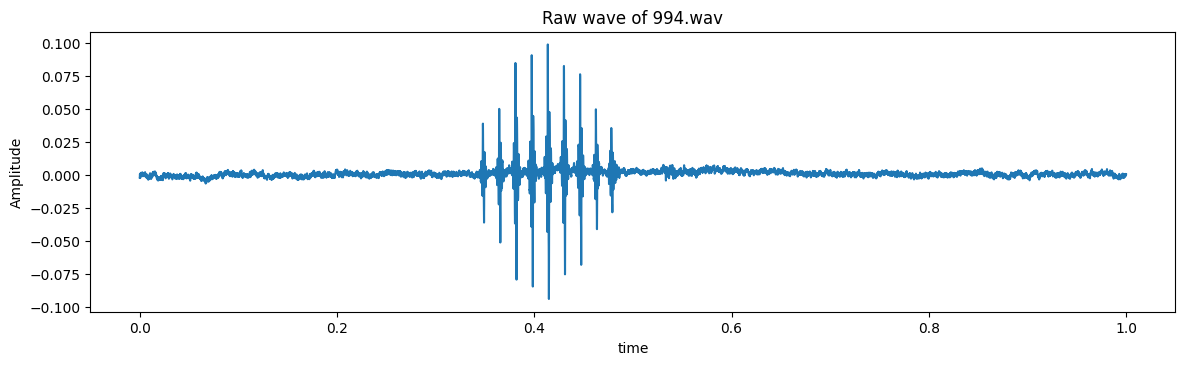

In [22]:
# plot audio using matplotlib
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(211)
ax.set_title('Raw wave of ' + filepath)
ax.set_xlabel('time')
ax.set_ylabel('Amplitude')
ax.plot(np.linspace(0, duration, sample_rate), waveform)

plt.show()

In [23]:
# play audio inline
Audio(waveform, rate=sample_rate)

In [25]:
# resample audio
prev_sampling_rate = sample_rate
sample_rate = 8000

waveform = librosa.resample(waveform, orig_sr=prev_sampling_rate, target_sr=sample_rate)
waveform.shape

(8000,)

In [ ]:
# resample audio
prev_sampling_rate = sample_rate
sample_rate = 4000

# Use keyword arguments for orig_sr and target_sr
waveform = librosa.resample(waveform, orig_sr=prev_sampling_rate, target_sr=sample_rate)
waveform.shape

(8000,)

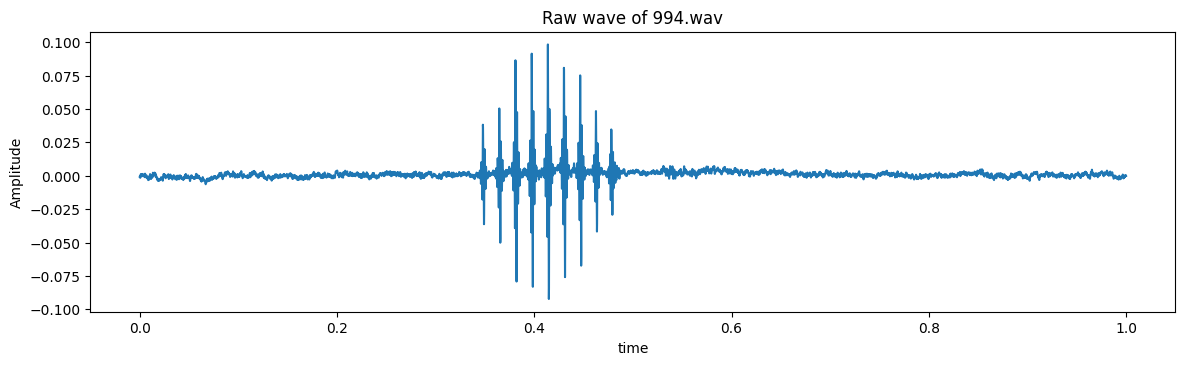

In [26]:
# plot audio using matplotlib
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(211)
ax.set_title('Raw wave of ' + filepath)
ax.set_xlabel('time')
ax.set_ylabel('Amplitude')

# Calculate the new duration based on the resampled waveform
duration = len(waveform) / sample_rate

ax.plot(np.linspace(0, duration, len(waveform)), waveform)

plt.show()

In [27]:
# play audio inline
Audio(waveform, rate=sample_rate)

In [32]:
# get all filepaths
filepaths = []

for dirname in os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/'):
    for filename in os.listdir('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/' + dirname):
        if filename.endswith('.wav'):
            filepaths.append('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/' + dirname + '/' + filename)

In [33]:
# print number of audio files
len(filepaths)

5136

In [34]:
# print one filepath
filepaths[0]

'/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands/down/1313.wav'

In [36]:
# get class
filepaths[0].split('/')[7]

'down'

In [37]:
# load audio file using torchaudio
waveform, sample_rate = torchaudio.load(filepaths[0])

In [38]:
# print shape and sampling rate
waveform.shape, sample_rate

(torch.Size([1, 16000]), 16000)

#### 1.3 Load data using custom Dataloader

In [40]:
# dictionary to convert categories to numerical labels
classes_to_labels = {
    'up': 0,
    'down': 1,
    'left': 2,
    'right': 3
}

# dictionary to convert numerical labels to categories
labels_to_classes = {
    0: 'up',
    1: 'down',
    2: 'left',
    3: 'right'
}

# define custom dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, data_dir):
        """Initialize dataset"""

        # get all audio filepaths
        self.filepaths = []
        for dirname in os.listdir(data_dir):
            for filename in os.listdir(data_dir + '/' + dirname):
                if filename.endswith('.wav'):
                    self.filepaths.append(data_dir + '/' + dirname + '/' + filename)

    def __len__(self):
        """Get length of dataset"""
        return len(self.filepaths)

    def __getitem__(self, idx):
        """Load and preprocess individual file"""

        # load audio file and the respective class
        waveform, sample_rate = torchaudio.load(self.filepaths[idx])
        class_name = self.filepaths[idx].split('/')[7]

        # trim or pad the audio file if required
        if waveform.shape[1] > sample_rate:
            waveform = waveform[:, :sample_rate]
        elif waveform.shape[1] < sample_rate:
            pad_len = sample_rate - waveform.shape[1]
            waveform = ConstantPad1d((0, pad_len), 0)(waveform)

        # resample audio
        waveform = Resample(orig_freq=sample_rate, new_freq=8000)(waveform)

        # normalize data
        waveform = waveform - waveform.min()
        waveform = waveform / waveform.max()

        # label encode the target variable
        label = classes_to_labels[class_name]

        return waveform, label

In [41]:
# create instance of custom dataset
dataset = SpeechCommandsDataset('/content/drive/MyDrive/AnalyticsVidya/NLP_DL/speech_commands')

# create dataloader
data_loader = DataLoader(
    dataset,
    batch_size=128,
    num_workers=4,
    shuffle=True
)

In [42]:
# check for one iteration of loop
for batch_x, batch_y in data_loader:
    break

In [43]:
# get shapes of batches
batch_x.shape, batch_y.shape

(torch.Size([128, 1, 8000]), torch.Size([128]))

In [44]:
# check data at random index
idx = choice(range(len(batch_y)))

waveform, label = batch_x[idx], batch_y[idx]

In [45]:
# print shape
waveform.shape

torch.Size([1, 8000])

In [46]:
# print min and max values of data
waveform.min(), waveform.max()

(tensor(0.), tensor(1.))

In [47]:
Audio(waveform, rate=8000)

In [48]:
# check target
label

tensor(1)

In [49]:
# map to actual class
labels_to_classes[int(label)]

'down'

### 2. Speech Commands Identification using CNN

#### 2.1 Define model architecture

In [51]:
# define model architecture

# Input

# Conv1D(num_filters=64, filter_size=13, stride=1, activation='relu')
# MaxPool(pool_size=3)
# Conv1D(num_filters=64, filter_size=13, stride=1, activation='relu')
# MaxPool(pool_size=3)
# Conv1D(num_filters=64, filter_size=13, stride=1, activation='relu')
# MaxPool(pool_size=3)
# Conv1D(num_filters=64, filter_size=13, stride=1, activation='relu')
# MaxPool(pool_size=3)

# Flatten
# Dense(num_neurons=256, activation='relu')  (floor((64- 13 + 2* 1)/ 1)+ 1)*4*4*2
# Dropout(0.3)
# Dense(num_neurons=32, activation='relu')
# Dropout(0.3)
# Dense(num_neurons=4, activation='softmax')


model = Sequential(
    Conv1d(in_channels=1, out_channels=64, kernel_size=13),
    ReLU(),
    MaxPool1d(4),

    Conv1d(in_channels=64, out_channels=64, kernel_size=13),
    ReLU(),
    MaxPool1d(4),

    Conv1d(in_channels=64, out_channels=64, kernel_size=13),
    ReLU(),
    MaxPool1d(4),

    Conv1d(in_channels=64, out_channels=64, kernel_size=13),
    ReLU(),
    MaxPool1d(4),

    Flatten(),

    Linear(1728, 256),
    ReLU(),
    Dropout(0.3),

    Linear(256, 32),
    ReLU(),
    Dropout(0.3),

    Linear(32, 4)
)

In [52]:
print(summary(model, batch_x[:1]))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv1d-1       [1, 64, 7988]             896             896
            ReLU-2       [1, 64, 7988]               0               0
       MaxPool1d-3       [1, 64, 1997]               0               0
          Conv1d-4       [1, 64, 1985]          53,312          53,312
            ReLU-5       [1, 64, 1985]               0               0
       MaxPool1d-6        [1, 64, 496]               0               0
          Conv1d-7        [1, 64, 484]          53,312          53,312
            ReLU-8        [1, 64, 484]               0               0
       MaxPool1d-9        [1, 64, 121]               0               0
         Conv1d-10        [1, 64, 109]          53,312          53,312
           ReLU-11        [1, 64, 109]               0               0
      MaxPool1d-12         [1, 64, 27]               0               0
     

In [53]:
# check model on one audio file
model.eval()

output = model(batch_x[:1])
output.shape

torch.Size([1, 4])

In [54]:
# print output
output

tensor([[0.1626, 0.0137, 0.0526, 0.0296]], grad_fn=<AddmmBackward0>)

#### 2.2 Train the model

In [55]:
# transfer model to GPU
model = model.to("cuda")

In [56]:
# define optimization and loss function
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [57]:
# set model to train
model.train()

# train model
for epoch in range(10):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").type(torch.cuda.FloatTensor)
        batch_y = batch_y.to("cuda").type(torch.cuda.LongTensor)

        # clear gradients
        optimizer.zero_grad()

        # pass audio to model
        outputs = model(batch_x)

        outputs = outputs.squeeze()

        # get loss
        loss = criterion(outputs, batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {:.5f} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 1.37482 
Training loss for epoch 2 is 1.20215 
Training loss for epoch 3 is 0.66354 
Training loss for epoch 4 is 0.31259 
Training loss for epoch 5 is 0.20343 
Training loss for epoch 6 is 0.15133 
Training loss for epoch 7 is 0.13464 
Training loss for epoch 8 is 0.10818 
Training loss for epoch 9 is 0.08311 
Training loss for epoch 10 is 0.06500 


#### 2.3 Get inference

In [77]:
# check model on one audio file
model.eval()

output = model(batch_x[:1]).cpu().detach()
output.shape

torch.Size([1, 4])

In [78]:
# output logits
output

tensor([[-3.6668, -0.5431, -3.2914,  5.1190]])

In [79]:
# get predicted label
output = torch.log_softmax(output, dim=1)
_, pred = torch.max(output, dim = 1)
pred

tensor([3])

In [80]:
# convert label to class
labels_to_classes[pred.numpy()[0]]

'right'

In [81]:
# visualize audio
Audio(batch_x[:1].cpu().detach().numpy()[0, 0, :], rate=8000)

In [82]:
# print actual label
batch_y[:1], labels_to_classes[batch_y[:1].cpu().numpy()[0]]

(tensor([3], device='cuda:0'), 'right')

In [66]:
# save model
torch.save(model.state_dict(), 'saved_model.pth')